# Algorithm

### Import modules

In [97]:
import numpy as np
import random 
import time
import csv
from datetime import datetime
from datetime import timedelta
import pandas as pd
from statistics import mean
import logging
import uuid
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

In [2]:
logging.basicConfig(filename="log_pacing.log", level=logging.INFO)

### Creation of the pacing Class (Speed algorithm)

In [3]:
class Algo:
    def __init__(self, daily_budget, nb_hours_day):
        """Class constructor"""
        # Fixed attributes
        self.daily_budget = daily_budget
        self.target = daily_budget/(nb_hours_day*3600)
        # Impossible day to initialize the setup
        self.day = 0
    
    def buying_decision(self, ts, price):
        """From a BR, decide whether to buy or not
        
        Arguments:
        :ts: timestamp of the BR
        :price: price of the BR
        """
        # TS de la br
        day = datetime.fromtimestamp(ts).day
        month = datetime.fromtimestamp(ts).month
        year = datetime.fromtimestamp(ts).year
        # If we begin a new day, we reset variables
        if self.day != day:
            logging.info("-\n CHANGING DAY \n")
            self.remaining_budget = self.daily_budget
            self.BT = [self.target]
            self.speed = pd.DataFrame({'V':0}, index=[datetime(year,month,day,6,0,0,0)])
            self.engaged_budget = 0
            self.spent_budget = 0
        self.day = day
        # Remaining time before the end of day
        end_day = datetime(year,month,day,19,40,0,0)
        remaining_time =  datetime.timestamp(end_day) - ts
        # Calculation of bt
        created_time = self.speed.index[-1] - timedelta(minutes=30)
        self.remaining_budget = self.daily_budget - (self.engaged_budget + self.spent_budget)
        try:
            bt = self.remaining_budget * ((1+100*self.speed.V[self.speed.index > created_time].mean()) / remaining_time) 
        except ZeroDivisionError:
            bt = 1
        if bt < 0:
            bt = 1
        self.BT.append(bt)
        # Calculation of vt
        vt = self.BT[-1] - self.BT[-2] 
        self.speed = self.speed.append(pd.DataFrame({'V':vt}, index=[datetime.fromtimestamp(ts)]))
        if (bt >= self.target or bt<=0) and (self.remaining_budget - price) >= 0:
            buying = True
            self.engaged_budget += price
        else:
            buying = False

        return (buying, bt, vt)     

    def send_pending_notifications(self,current_ts = None):
        """ Send notifications 
        
        :param current_ts: if None: will send all notifications, else send before current_ts
        :return:
        """
        while len(pending_notifications) > 0 and (pending_notifications[0]['timestamp'] <= current_ts if current_ts else True):
            ev = pending_notifications.pop(0)
            logging.info(f"{ev['timestamp']} -> Sending {ev['status']} notif with ID {ev['id']}")
            if ev['status'] == 'win':
                self.engaged_budget -= ev['br_price']
                self.spent_budget += ev['br_price']
            else:
                self.engaged_budget -= ev['br_price']

In [4]:
data = pd.read_csv('09-07-2020_07-08-2020.csv', index_col="timestamp_string", parse_dates=True)
data.index.names = ['Date']
data.head()

,ID,timestamp,nb_imp,price,win,seconds_notif
Date,,,,,,
2020-07-09 06:00:00,1,1.594267e+09,2,2,True,381
2020-07-09 06:00:01,2,1.594267e+09,1,1,True,800
2020-07-09 06:00:02,3,1.594267e+09,0,0,True,578
2020-07-09 06:00:04,4,1.594267e+09,0,0,True,583
2020-07-09 06:00:06,5,1.594267e+09,0,0,True,625


In [5]:
pacing = Algo(daily_budget=3000, nb_hours_day=14)

In [6]:
buyings = list()
remaining = list()
bt = list()
target = list()
vt = list()
spent = list()
engaged = list()
pending_notifications = list()
day = 9
for current_ts, row in data.iterrows():
    # Send current notifications
    pacing.send_pending_notifications(current_ts)
    if current_ts.day != day:
        day = current_ts.day
        engaged[-1] = pacing.engaged_budget
        pacing.remaining_budget = pacing.daily_budget - (pacing.engaged_budget + pacing.spent_budget)
        remaining[-1] = pacing.remaining_budget
        spent[-1] = pacing.spent_budget
    
    # Receive BR
    decision = pacing.buying_decision(row['timestamp'], row['price'])
    logging.info(f"{current_ts} -> sending BR")
    # Making a decision
    if decision[0]:
        #Buying
        logging.info(f"{current_ts} <- receiving buy")
        next_notif_ts = current_ts + timedelta(seconds=row['seconds_notif'])
        status = "win" if row['win'] else "lose"
        notif_id = uuid.uuid4()
        logging.info(f" | {current_ts} decided {status}, will be notified at {next_notif_ts} with ID {notif_id}")
        pending_notifications.append({"timestamp": next_notif_ts, "status": status, 'br_price': row['price'], 'id': notif_id})
        pending_notifications.sort(key=lambda x: x['timestamp'])
    target.append(pacing.target)
    bt.append(decision[1])
    vt.append(decision[2])
    buyings.append(decision[0])
    remaining.append(pacing.remaining_budget)
    spent.append(pacing.spent_budget)
    engaged.append(pacing.engaged_budget)
# Send remaining notifications
pacing.send_pending_notifications()
# Update last row after sending last notifications
engaged[-1] = pacing.engaged_budget
pacing.remaining_budget = pacing.daily_budget - (pacing.engaged_budget + pacing.spent_budget)
remaining[-1] = pacing.remaining_budget
spent[-1] = pacing.spent_budget
data['target'] = target
data['bt'] = bt
data['vt'] = vt
data['buying'] = buyings
data['remaining_budget'] = remaining
data['engaged_budget'] = engaged
data['spent_budget'] = spent

In [7]:
data.to_csv('pacing(vt)_09-07-2020_07-08-2020.csv', index=True)

### Creation of the pacing Class (Acceleration algorithm)

In [28]:
class Algo:
    def __init__(self, daily_budget, nb_hours_day):
        """Class constructor"""
        # Fixed attributes
        self.daily_budget = daily_budget
        self.target = daily_budget/(nb_hours_day*3600)
        # Impossible day to initialize the setup
        self.day = 0
    
    def buying_decision(self, ts, price):
        """From a BR, decide whether to buy or not
        
        Arguments:
        :ts: timestamp of the BR
        :price: price of the BR
        """
        # TS de la br
        day = datetime.fromtimestamp(ts).day
        month = datetime.fromtimestamp(ts).month
        year = datetime.fromtimestamp(ts).year
        # If we begin a new day, we reset variables
        if self.day != day:
            logging.info("-\n CHANGING DAY \n")
            self.remaining_budget = self.daily_budget
            self.BT = [self.target]
            self.acceleration = pd.DataFrame({'A':0}, index=[datetime(year,month,day,6,0,0,0)])
            self.speed = [0]
            self.engaged_budget = 0
            self.spent_budget = 0
        self.day = day
        # Remaining time before the end of the day
        end_day = datetime(year,month,day,19,40,0,0)
        remaining_time =  datetime.timestamp(end_day) - ts
        # Calculation of bt
        created_time = self.acceleration.index[-1] - timedelta(minutes=30)
        self.remaining_budget = self.daily_budget - (self.engaged_budget + self.spent_budget)
        try:
            bt = self.remaining_budget * ((1+100*self.acceleration.A[self.acceleration.index > created_time].mean()) / remaining_time) 
        except ZeroDivisionError:
            bt = 1
        if bt < 0:
            bt = 1
        self.BT.append(bt)
        # Calculation of vt
        vt = self.BT[-1] - self.BT[-2] 
        self.speed.append(vt)
        at = self.speed[-1] - self.speed[-2]
        self.acceleration = self.acceleration.append(pd.DataFrame({'A':at}, index=[datetime.fromtimestamp(ts)]))
        if (bt >= self.target or bt<=0) and (self.remaining_budget - price) >= 0:
            buying = True
            self.engaged_budget += price
        else:
            buying = False

        return (buying, bt, at)     

    def send_pending_notifications(self,current_ts = None):
        """ Send notifications 
        
        :param current_ts: if None: will send all notifications, else send before current_ts
        :return:
        """
        while len(pending_notifications) > 0 and (pending_notifications[0]['timestamp'] <= current_ts if current_ts else True):
            ev = pending_notifications.pop(0)
            logging.info(f"{ev['timestamp']} -> Sending {ev['status']} notif with ID {ev['id']}")
            if ev['status'] == 'win':
                self.engaged_budget -= ev['br_price']
                self.spent_budget += ev['br_price']
            else:
                self.engaged_budget -= ev['br_price']

In [29]:
data = pd.read_csv('wd_10-07-2020_08-08-2020.csv', index_col="timestamp_string", parse_dates=True)
data.index.names = ['Date']

In [30]:
pacing = Algo(daily_budget=3000, nb_hours_day=14)

In [31]:
buyings = list()
remaining = list()
bt = list()
target = list()
at = list()
spent = list()
engaged = list()
pending_notifications = list()
day = 10
for current_ts, row in data.iterrows():
    # Send current notifications
    pacing.send_pending_notifications(current_ts)
    if current_ts.day != day:
        day = current_ts.day
        engaged[-1] = pacing.engaged_budget
        pacing.remaining_budget = pacing.daily_budget - (pacing.engaged_budget + pacing.spent_budget)
        remaining[-1] = pacing.remaining_budget
        spent[-1] = pacing.spent_budget
    
    # Receive BR
    decision = pacing.buying_decision(row['timestamp'], row['price'])
    logging.info(f"{current_ts} -> sending BR")
    # Making a decision
    if decision[0]:
        #Buying
        logging.info(f"{current_ts} <- receiving buy")
        next_notif_ts = current_ts + timedelta(seconds=row['seconds_notif'])
        status = "win" if row['win'] else "lose"
        notif_id = uuid.uuid4()
        logging.info(f" | {current_ts} decided {status}, will be notified at {next_notif_ts} with ID {notif_id}")
        pending_notifications.append({"timestamp": next_notif_ts, "status": status, 'br_price': row['price'], 'id': notif_id})
        pending_notifications.sort(key=lambda x: x['timestamp'])
    target.append(pacing.target)
    bt.append(decision[1])
    at.append(decision[2])
    buyings.append(decision[0])
    remaining.append(pacing.remaining_budget)
    spent.append(pacing.spent_budget)
    engaged.append(pacing.engaged_budget)
# Send remaining notifications
pacing.send_pending_notifications()
# Update last row after sending last notifications
engaged[-1] = pacing.engaged_budget
pacing.remaining_budget = pacing.daily_budget - (pacing.engaged_budget + pacing.spent_budget)
remaining[-1] = pacing.remaining_budget
spent[-1] = pacing.spent_budget
data['target'] = target
data['bt'] = bt
data['at'] = at
data['buying'] = buyings
data['remaining_budget'] = remaining
data['engaged_budget'] = engaged
data['spent_budget'] = spent

In [32]:
data.groupby(data.index.day).tail(1)

,ID,weekday,timestamp,nb_imp,price,win,seconds_notif,target,bt,at,buying,remaining_budget,engaged_budget,spent_budget
Date,,,,,,,,,,,,,,
2020-07-10 19:50:35,1653,4,1.594403e+09,2,2,True,117,0.059524,1.000000e+00,-7.349600e+19,True,788,0,2212
2020-07-11 19:42:32,2759,5,1.594489e+09,5,5,True,144,0.059524,5.079837e+20,6.408410e+20,True,490,0,2510
2020-07-12 19:59:59,4768,6,1.594577e+09,4,4,True,288,0.059524,1.000000e+00,0.000000e+00,False,1,0,2999
2020-07-13 19:54:56,6522,0,1.594663e+09,2,2,True,684,0.059524,-0.000000e+00,0.000000e+00,False,0,0,3000
2020-07-14 19:54:27,8518,1,1.594749e+09,8,8,True,93,0.059524,-0.000000e+00,0.000000e+00,False,0,0,3000
2020-07-15 19:59:58,10123,2,1.594836e+09,0,0,True,429,0.059524,-0.000000e+00,0.000000e+00,True,0,0,3000
2020-07-16 19:59:59,12211,3,1.594922e+09,1,1,True,322,0.059524,-0.000000e+00,0.000000e+00,False,5,0,2995
2020-07-17 19:56:11,13782,4,1.595009e+09,3,3,True,704,0.059524,1.000000e+00,-2.304299e+27,True,975,0,2025
2020-07-18 19:57:21,15361,5,1.595095e+09,0,0,False,33,0.059524,1.000000e+00,-2.521398e+42,True,867,0,2133


In [12]:
data.to_csv('pacing(at)_09-07-2020_07-08-2020.csv', index=True)

### Creation of the pacing Class (Acceleration + evolutive target algorithm)

In [101]:
class Algo:
    def __init__(self, daily_budget, nb_hours_day, prop_table):
        """Class constructor"""
        # Fixed attributes
        self.daily_budget = daily_budget
        self.prop_table = prop_table
        # Impossible day to initialize the setup
        self.day = 0
    
    def buying_decision(self, ts, price):
        """From a BR, decide whether to buy or not
        
        Arguments:
        :ts: timestamp of the BR
        :price: price of the BR
        """
        # TS de la BR
        weekday = datetime.fromtimestamp(ts).weekday()
        day = datetime.fromtimestamp(ts).day
        month = datetime.fromtimestamp(ts).month
        year = datetime.fromtimestamp(ts).year
        hour = datetime.fromtimestamp(ts).hour
        # Evolutive target
        self.budget_hour = (self.prop_table.loc[hour, str(weekday)]/100)*self.daily_budget
        self.target = self.budget_hour/3600
        # If we begin a new day, we reset variables
        if self.day != day:
            logging.info("-\n CHANGING DAY \n")
            self.remaining_budget = self.daily_budget
            self.BT = [self.target]
            self.acceleration = pd.DataFrame({'A':0}, index=[datetime(year,month,day,6,0,0,0)])
            self.speed = [0]
            self.engaged_budget = 0
            self.spent_budget = 0
        self.day = day
        # Remaining time before the end of the hour
        end_hour = datetime(year,month,day,hour+1,0,0,0)
        remaining_time =  datetime.timestamp(end_hour) - ts
        # Calculation of bt
        created_time = self.acceleration.index[-1] - timedelta(minutes=30)
        self.remaining_budget = self.daily_budget - (self.engaged_budget + self.spent_budget)
        self.remaining_budget_hour = ((self.prop_table.loc[hour, str(weekday)]/100)*self.daily_budget) - (self.engaged_budget + self.spent_budget)
        try:
            bt = self.remaining_budget_hour * ((1+0.1*self.acceleration.A[self.acceleration.index > created_time].mean()) / remaining_time) 
        except ZeroDivisionError:
            bt = 1
        self.BT.append(bt)
        # Calculation of vt
        vt = self.BT[-1] - self.BT[-2] 
        self.speed.append(vt)
        at = self.speed[-1] - self.speed[-2]
        self.acceleration = self.acceleration.append(pd.DataFrame({'A':at}, index=[datetime.fromtimestamp(ts)]))
        if (bt >= self.target or bt<=0) and (self.remaining_budget_hour - price) >= 0:
            buying = True
            self.engaged_budget += price
        else:
            buying = False

        return (buying, bt, at)     

    def send_pending_notifications(self,current_ts = None):
        """ Send notifications 
        
        :param current_ts: if None: will send all notifications, else send before current_ts
        :return:
        """
        while len(pending_notifications) > 0 and (pending_notifications[0]['timestamp'] <= current_ts if current_ts else True):
            ev = pending_notifications.pop(0)
            logging.info(f"{ev['timestamp']} -> Sending {ev['status']} notif with ID {ev['id']}")
            if ev['status'] == 'win':
                self.engaged_budget -= ev['br_price']
                self.spent_budget += ev['br_price']
            else:
                self.engaged_budget -= ev['br_price']

In [102]:
data = pd.read_csv('wd_10-07-2020_08-08-2020.csv', index_col="timestamp_string", parse_dates=True)
data.index.names = ['Date']
prop = pd.read_csv('proportion_table.csv', index_col = 'hour')

In [103]:
pacing = Algo(daily_budget=3000, nb_hours_day=14, prop_table = prop)

In [104]:
buyings = list()
remaining = list()
bt = list()
target = list()
at = list()
spent = list()
engaged = list()
pending_notifications = list()
day = 10
for current_ts, row in data.iterrows():
    # Send current notifications
    pacing.send_pending_notifications(current_ts)
    if current_ts.day != day:
        day = current_ts.day
        engaged[-1] = pacing.engaged_budget
        pacing.remaining_budget = pacing.daily_budget - (pacing.engaged_budget + pacing.spent_budget)
        remaining[-1] = pacing.remaining_budget
        spent[-1] = pacing.spent_budget
    
    # Receive BR
    decision = pacing.buying_decision(row['timestamp'], row['price'])
    logging.info(f"{current_ts} -> sending BR")
    # Making a decision
    if decision[0]:
        #Buying
        logging.info(f"{current_ts} <- receiving buy")
        next_notif_ts = current_ts + timedelta(seconds=row['seconds_notif'])
        status = "win" if row['win'] else "lose"
        notif_id = uuid.uuid4()
        logging.info(f" | {current_ts} decided {status}, will be notified at {next_notif_ts} with ID {notif_id}")
        pending_notifications.append({"timestamp": next_notif_ts, "status": status, 'br_price': row['price'], 'id': notif_id})
        pending_notifications.sort(key=lambda x: x['timestamp'])
    target.append(pacing.target)
    bt.append(decision[1])
    at.append(decision[2])
    buyings.append(decision[0])
    remaining.append(pacing.remaining_budget)
    spent.append(pacing.spent_budget)
    engaged.append(pacing.engaged_budget)
# Send remaining notifications
pacing.send_pending_notifications()
# Update last row after sending last notifications
engaged[-1] = pacing.engaged_budget
pacing.remaining_budget = pacing.daily_budget - (pacing.engaged_budget + pacing.spent_budget)
remaining[-1] = pacing.remaining_budget
spent[-1] = pacing.spent_budget
data['target'] = target
data['bt'] = bt
data['at'] = at
data['buying'] = buyings
data['remaining_budget'] = remaining
data['engaged_budget'] = engaged
data['spent_budget'] = spent

In [105]:
data.groupby(data.index.day).tail(1)

,ID,weekday,timestamp,nb_imp,price,win,seconds_notif,target,bt,at,buying,remaining_budget,engaged_budget,spent_budget
Date,,,,,,,,,,,,,,
2020-07-10 19:50:35,1653,4,1.594403e+09,2,2,True,117,0.100000,-0.635395,-0.005647,False,2281,0,719
2020-07-11 19:42:32,2759,5,1.594489e+09,5,5,True,144,0.083333,-0.285305,-0.002212,False,2401,0,599
2020-07-12 19:59:59,4768,6,1.594577e+09,4,4,True,288,0.041667,-231.910587,-216.955685,False,2614,0,386
2020-07-13 19:54:56,6522,0,1.594663e+09,2,2,True,684,0.083333,-0.289472,-0.001049,False,2612,0,388
2020-07-14 19:54:27,8518,1,1.594749e+09,8,8,True,93,0.083333,-0.588585,0.003186,False,2504,0,496
2020-07-15 19:59:58,10123,2,1.594836e+09,0,0,True,429,0.075000,-101.820556,-56.294342,False,2524,0,476
2020-07-16 19:59:59,12211,3,1.594922e+09,1,1,True,322,0.075000,-191.992570,-93.276192,False,2533,0,467
2020-07-17 19:56:11,13782,4,1.595009e+09,3,3,True,704,0.100000,-1.497746,0.018548,False,2297,0,703
2020-07-18 19:57:21,15361,5,1.595095e+09,0,0,False,33,0.083333,-1.842599,0.009630,False,2407,0,593


In [106]:
jour = data['2020-07-10 06:00:00':'2020-07-10 20:00:00']

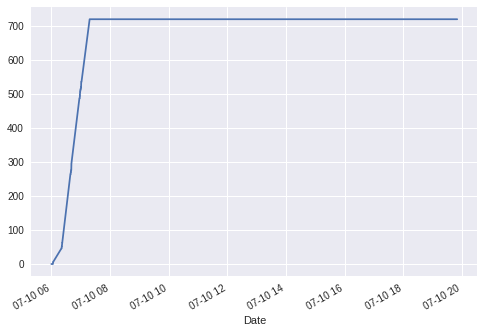

In [109]:
jour.spent_budget.plot()

In [108]:
jour

,ID,weekday,timestamp,nb_imp,price,win,seconds_notif,target,bt,at,buying,remaining_budget,engaged_budget,spent_budget
Date,,,,,,,,,,,,,,
2020-07-10 06:00:00,1,4,1.594354e+09,1,1,True,278,0.2,0.200000,0.000000,True,3000,1,0
2020-07-10 06:00:01,2,4,1.594354e+09,1,1,True,274,0.2,0.199778,-0.000222,False,2999,1,0
2020-07-10 06:00:02,3,4,1.594354e+09,2,2,True,512,0.2,0.199832,0.000276,False,2999,1,0
2020-07-10 06:00:03,4,4,1.594354e+09,3,3,True,395,0.2,0.199889,0.000003,False,2999,1,0
2020-07-10 06:00:04,5,4,1.594354e+09,9,9,True,89,0.2,0.199945,-0.000002,False,2999,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-10 19:50:09,1649,4,1.594403e+09,4,4,True,325,0.1,-0.607443,-0.002149,False,2281,0,719
2020-07-10 19:50:13,1650,4,1.594403e+09,2,2,True,41,0.1,-0.611579,0.001969,False,2281,0,719
2020-07-10 19:50:22,1651,4,1.594403e+09,5,5,True,330,0.1,-0.621105,-0.005389,False,2281,0,719
